In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['ISX'] = '0'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from dewan_calcium.helpers.project_folder import ProjectFolder
from dewan_calcium import classifiers
pd.options.mode.copy_on_write = "warn"

print('Finished importing required libraries!')

Finished importing required libraries!


In [4]:
# Create Project Folder to Gather and Hold all the File Paths
project_folder = ProjectFolder('ODOR', project_dir=r'/home/austin/Combined/Identity', combined=True)

{Odor List} not found in /home/austin/Combined/Identity/Raw_Data


In [5]:
# If this is the first time the project folder has been created,
# move the files to the appropriate directories and then run this cell, otherwise skip this cell
project_folder.get_data()

{Odor List} not found in /home/austin/Combined/Identity/Raw_Data


In [6]:
cell_class = 'VGAT'
data_file = []
for file in project_folder.raw_data_dir.combined_data_path:
    if cell_class.lower() in str(file).lower():
        data_file = file
        break
        
if not data_file:
    raise FileExistsError(f'No data file with class {cell_class} exists!')

In [30]:
from pathlib import Path
data_file = Path('/mnt/r2d2/2_Inscopix/1_DTT/1_OdorAnalysis/2_Identity/VGLUT/VGLUT-27_RERUN/Analysis/Output/combined/VGLUT27_ID-8_15_24-combined_data_shift.pickle')
#37 looks funky

In [31]:
combined_data = pd.read_pickle(data_file)
z_scored_combined_data = combined_data.T.groupby(level=0, group_keys=False).apply(stats.zscore).T
# Transform our dataframe to put the cells/odors as the index, group by level=0 (cell names), apply stats.zscore to each group, transform back

cells = np.unique(combined_data.columns.get_level_values(0).values)

In [32]:
# Sliding Window Decoding
WINDOW = 5
mean_svm_scores, splits_v_repeat_df, all_confusion_mats, (true_labels, pred_labels) = classifiers.sliding_window_ensemble_decoding(z_scored_combined_data, window_size=WINDOW, num_splits=50)
output_dir = project_folder.analysis_dir.output_dir.subdir(cell_class)

mean_score_df = pd.DataFrame(mean_svm_scores, np.arange(len(mean_svm_scores)))
mean_score_df.insert(0, column='num_cells',value=len(cells))

if WINDOW:
    mean_score_df.insert(0, column='window_size', value=WINDOW)
    output_dir = output_dir.joinpath(f'Window-{WINDOW}')
    if not output_dir.exists():
        output_dir.mkdir()

mean_score_df.to_excel(output_dir.joinpath('mean_svm_scores.xlsx'))
mean_scores_path = output_dir.joinpath('mean_svm_scores.pickle')
pd.to_pickle(mean_svm_scores, mean_scores_path)
splits_path = output_dir.joinpath('splits_v_repeat_df.pickle')
pd.to_pickle(splits_v_repeat_df, splits_path)
all_confusion_mat_path = output_dir.joinpath('all_confusion_mat.pickle')
pd.to_pickle(all_confusion_mats, all_confusion_mat_path)
labels_path = output_dir.joinpath('labels.pickle')
pd.to_pickle((true_labels, pred_labels), labels_path)

Sliding Window Ensemble Decoding:   0%|          | 0/12 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(0), np.int64(5)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(5), np.int64(10)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(10), np.int64(15)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(15), np.int64(20)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(20), np.int64(25)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(25), np.int64(30)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(30), np.int64(35)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(35), np.int64(40)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(40), np.int64(45)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(45), np.int64(50)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(50), np.int64(55)):   0%|          | 0/123 [00:00<?, ?it/s]

Randomly Sampling Cells for window size (np.int64(53), np.int64(58)):   0%|          | 0/123 [00:00<?, ?it/s]

In [ ]:
# Sliding Window Decoding
shuffled_data = classifiers.shuffle_data(z_scored_combined_data)

shuffled_mean_svm_scores, shuffled_splits_v_repeat_df, shuffled_all_confusion_mats, (shuffled_true_labels, shuffled_pred_labels) = classifiers.sliding_window_ensemble_decoding(shuffled_data, window_size=WINDOW, num_splits=50)
output_dir = project_folder.analysis_dir.output_dir.subdir(cell_class)

shuffled_mean_score_df = pd.DataFrame(shuffled_mean_svm_scores, np.arange(len(shuffled_mean_svm_scores)))
shuffled_mean_score_df.insert(0, column='num_cells',value=len(cells))

if WINDOW:
    shuffled_mean_score_df.insert(0, column='window_size', value=WINDOW)
    output_dir = output_dir.joinpath(f'Window-{WINDOW}')
    if not output_dir.exists():
        output_dir.mkdir()
        
shuffled_mean_score_df.to_excel(output_dir.joinpath('shuffle_mean_svm_scores.xlsx'))
shuffled_mean_scores_path = output_dir.joinpath('shuffle_mean_svm_scores.pickle')
pd.to_pickle(shuffled_mean_svm_scores, shuffled_mean_scores_path)
shuffled_splits_path = output_dir.joinpath('shuffle_splits_v_repeat_df.pickle')
pd.to_pickle(shuffled_splits_v_repeat_df, shuffled_splits_path)
shuffled_all_confusion_mat_path = output_dir.joinpath('shuffle_all_confusion_mat.pickle')
pd.to_pickle(shuffled_all_confusion_mats, shuffled_all_confusion_mat_path)
shuffled_labels_path = output_dir.joinpath('shuffle_labels.pickle')
pd.to_pickle((shuffled_true_labels, shuffled_pred_labels), shuffled_labels_path)

In [33]:
mean_performance = [mean_svm_scores[key] for key in mean_svm_scores]
# shuffle_mean_performance = [shuffled_mean_svm_scores[key] for key in shuffled_mean_svm_scores]

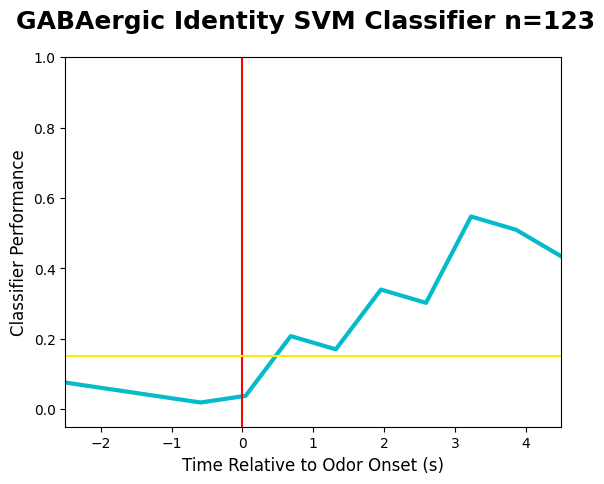

In [34]:
fig, ax = plt.subplots()
x_vals = np.linspace(-2.5, 4.5, len(mean_performance))
ax.plot(x_vals, mean_performance, color='#04BBC9', linewidth=3)
#ax.plot(x_vals, shuffle_mean_performance, color='#C500FF', linewidth=1)
ax.vlines(x=0, ymin=-1, ymax=1, color='r')
ax.hlines(y=0.15, xmin=-4, xmax=10, color='#FFEC00')
ax.set_ylim([-0.05, 1])
ax.set_xlim([-2.5, 4.5])
plt.suptitle(f'GABAergic Identity SVM Classifier n={len(cells)}', fontsize=18, fontweight='bold')
ax.set_ylabel('Classifier Performance', fontsize=12)
ax.set_xlabel('Time Relative to Odor Onset (s)', fontsize=12)
plt.savefig(output_dir.joinpath('GABA_Classifier.pdf'), dpi=600)

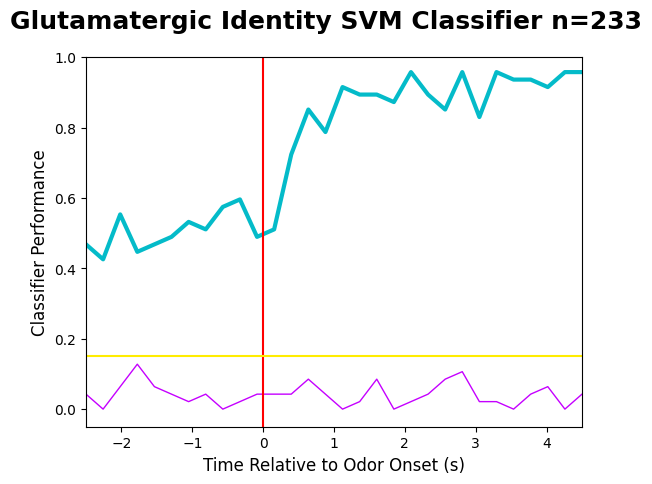

In [13]:
fig, ax = plt.subplots()
x_vals = np.linspace(-2.5, 4.5, len(mean_performance))
ax.plot(x_vals, mean_performance, color='#04BBC9', linewidth=3)
ax.plot(x_vals, shuffle_mean_performance, color='#C500FF', linewidth=1)
ax.vlines(x=0, ymin=-1, ymax=1, color='r')
ax.hlines(y=0.15, xmin=-4, xmax=10, color='#FFEC00')
ax.set_ylim([-0.05, 1])
ax.set_xlim([-2.5, 4.5])
plt.suptitle(f'Glutamatergic Identity SVM Classifier n={len(cells)}', fontsize=18, fontweight='bold')
ax.set_ylabel('Classifier Performance', fontsize=12)
ax.set_xlabel('Time Relative to Odor Onset (s)', fontsize=12)
plt.savefig(output_dir.joinpath('GLUT_Classifier.pdf'), dpi=600)